In [2]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
from CL_utilities.top5_efficiency import top5eff
import numpy as np
import keras
from CL_utilities import loss_function
import tensorflow as tf
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import Callback
from utilities.test_products_generator import TestProductsGenerator
from metrics.Metrics import Metrics
from keras.optimizers import SGD

In [3]:
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.6
training_pairs = 1400
validation_pairs = 300
training_path = r"./data/Fruits360/Training"
validation_path = r"./data/Fruits360/Validation"

In [6]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(100, 100, 3)


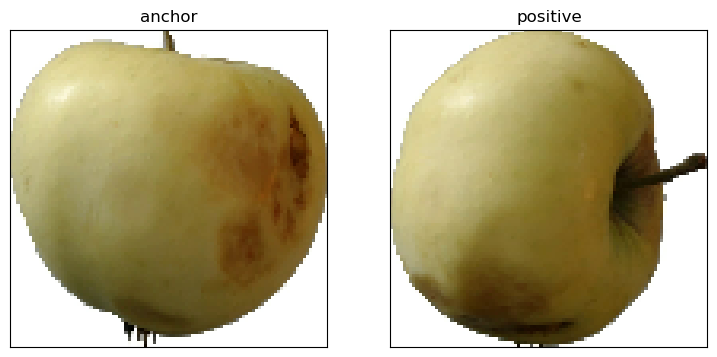

In [7]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

In [8]:
validation_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")

(100, 100, 3)


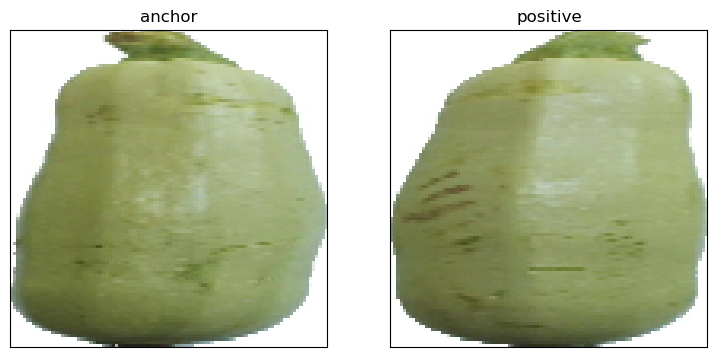

In [9]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

In [10]:
input_layer = keras.layers.Input((100,100,3))

x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(128, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
embedding_network = keras.Model(input_layer, x)   # create instance of model called embedding_network

In [11]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)
 
merge_layer_distance = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])
siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer_distance)

In [12]:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam')

In [13]:
#########################################################################################################################

In [14]:
# CREATE MEAN (of 5 IMAGES) REPRESENTATIVE VECTOR FOR EACH CLASS
import tensorflow as tf
from utilities.mapping import Mapper
import os
import random
import shutil

@staticmethod
class Representatives:
    def __init__(self, image_size):
        self.list_of_images = []
        self.list_of_labels = []
        self.List_mean_feature_vector_shop = np.zeros((24,16))
        self.image_size = image_size
        
    #RANDOM_REPRESENTATIVES
    def create_representatives(self, number_of_representative):
        self.number_of_representative = number_of_representative

        shop_path = os.path.abspath("data/Fruits360/Shop360_database")
        validation_path = r"./data/Fruits360/Validation/"

        for type_of_product in os.listdir(validation_path):
            val_dir = os.path.join(validation_path, type_of_product)
            shop_class_dir = os.path.join(shop_path, type_of_product)

            os.makedirs(shop_class_dir, exist_ok=True)

            for filename in os.listdir(shop_class_dir):
                file_path = os.path.join(shop_class_dir, filename)
                os.remove(file_path)

            files = [f for f in os.listdir(val_dir)]    #list of images

            for i in range(self.number_of_representative):
                random_selected_representative = random.choice(files)
                path_representative = os.path.join(val_dir,random_selected_representative)
                destination_path = os.path.join(shop_class_dir, random_selected_representative)
                shutil.copy(path_representative, destination_path)          
    def get_mean_representatives_for_each_class(self, fruit_names, fruit_paths, number_of_representative):
        self.fruits_names = fruit_names
        self.fruits_paths = fruit_paths
        self.number_repr = number_of_representative
        i=0
        j=0

        for i in range(len(fruits_paths)):
            for j in range(self.number_repr):
                path_to_image = Mapper(image_size)
                image = path_to_image._decode_and_resize(fruits_paths[i][j])
                self.list_of_images.append(image)
                self.list_of_labels.append(fruits_names[i])
            #print(list_of_labels)
        
            #___________________Get dimensions__________________________
            num_of_images = self.number_repr#len(list_of_images[0])  #one mean for each class
            size_feature_vector = embedding_network(tf.expand_dims(self.list_of_images[0], axis=0)).numpy()
            size_feature_vector = size_feature_vector.shape[1]   #get length
            #___________________________________________________________
            
            list_class_vectors = np.zeros((num_of_images, size_feature_vector))
                
            for num in range(self.number_repr):
                list_class_vectors[num] = embedding_network(tf.expand_dims(self.list_of_images[num], axis=0)).numpy()
            #print(list_class_vectors)    
                
            mean_feature_vector = np.mean(list_class_vectors, axis=0)   # mean vector for all representatives of class
            self.List_mean_feature_vector_shop[i] = mean_feature_vector
            print(fruits_names[i])
            print(self.List_mean_feature_vector_shop[i])
        
            self.list_of_images.clear()
            self.list_of_labels.clear()
            
        return self.List_mean_feature_vector_shop

In [15]:
def distance_between_vectors(vector1, vector2):
    vector1 = vector1 / tf.norm(vector1)   # length ov vector == 1
    vector2 = vector2 / tf.norm(vector2)
    sum_square = np.sum(np.square(vector1 - vector2))
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

In [16]:
import random
def create_test_images():
    camera_images_list = []
    camera_labels_list = []
    path_test_eff = 'data/Fruits360/Test'
    data = DatasetFactory.give_paths_to_test(path_test_eff, 1)
    
    
    # Losowo wybieranie 10 zdjęć z każdego folderu
    camera_paths = [random.sample(paths_list, 10) for paths_list in data.values() if len(paths_list) >= 10]
    camera_paths = [path for sublist in camera_paths for path in sublist]  # Spłaszczanie listy list
    camera_names = [path.split('/')[-2] for path in camera_paths]  # Zakładam, że nazwa folderu jest właściwym labelem
    
    
    camera_feature_vector = np.zeros((len(camera_paths), 16))
    print(len(camera_paths))
    # Dekodowanie i przetwarzanie obrazów
    for i in range(len(camera_paths)):
        path_to_image1 = Mapper(image_size)
        img  = path_to_image1._decode_and_resize(camera_paths[i])
        camera_images_list.append(img)
        camera_labels_list.append(camera_names[i])  
        camera_feature_vector[i] = embedding_network(tf.expand_dims(camera_images_list[i],axis=0)).numpy()
        
    # Obliczanie odległości między wektorami cech
    distances = np.zeros(24)  # Zakładam, że istnieje 22 kategorie
    for i in range(24):
        distances[i] = distance_between_vectors(camera_feature_vector, List_mean_feature_vector_shop[i])
        
    return camera_feature_vector, distances, camera_paths, camera_names

In [17]:

#num_of_imag_per_class = 10
#Representatives(image_size)#.create_representatives(num_of_imag_per_class)
        
camera_path = 'data/Fruits360/Shop360_database'
paths = DatasetFactory.give_paths_to_test(camera_path, 10)
fruits_names = []
fruits_paths = []
fruits_names = [key.split('/')[-1] for key in paths.keys()]
fruits_paths = [value for value in paths.values()]  # Get 5 representatives for each class

In [18]:
##############################################################################################################

In [19]:
# Callback to calculate TOP5 efficiency

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        
        num_img = 5
        object_of_representant = Representatives(image_size)
        global List_mean_feature_vector_shop
        List_mean_feature_vector_shop = object_of_representant.get_mean_representatives_for_each_class(fruits_names, fruits_paths, num_img)
        print(List_mean_feature_vector_shop)
        camera_feature_vector, distances, camera_paths, camera_names = create_test_images()
        
        efficiency = 0.
        eff_one_example = 0.
        for num_camera_images in range(len(camera_paths)):  #230 (10 images for each class)
            for i in range(24):
                distances[i] = distance_between_vectors(camera_feature_vector[num_camera_images], List_mean_feature_vector_shop[i])
            top5_dist, top5_lab = top5eff().find_top_5(distances, fruits_names)
            eff_one_example = top5eff().give_efficiency(camera_names[num_camera_images], top5_lab, top5_dist)
            efficiency += eff_one_example
            #if(eff_one_example <= 0.92):
                #print(top5_lab)
                #print(camera_names[num_camera_images])
                #print(camera_paths[num_camera_images])
        efficiency = efficiency/len(camera_paths)*100
        print(f"Efficiency of model in our metric: {efficiency}")
        logs['top5_metric'] = efficiency


In [20]:
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 16)        │    915,356 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 915,356 (3.49 MB)

 Trainable params: 915,222 (3.49 MB)

 Non-trainable params: 134 (536.00 B)

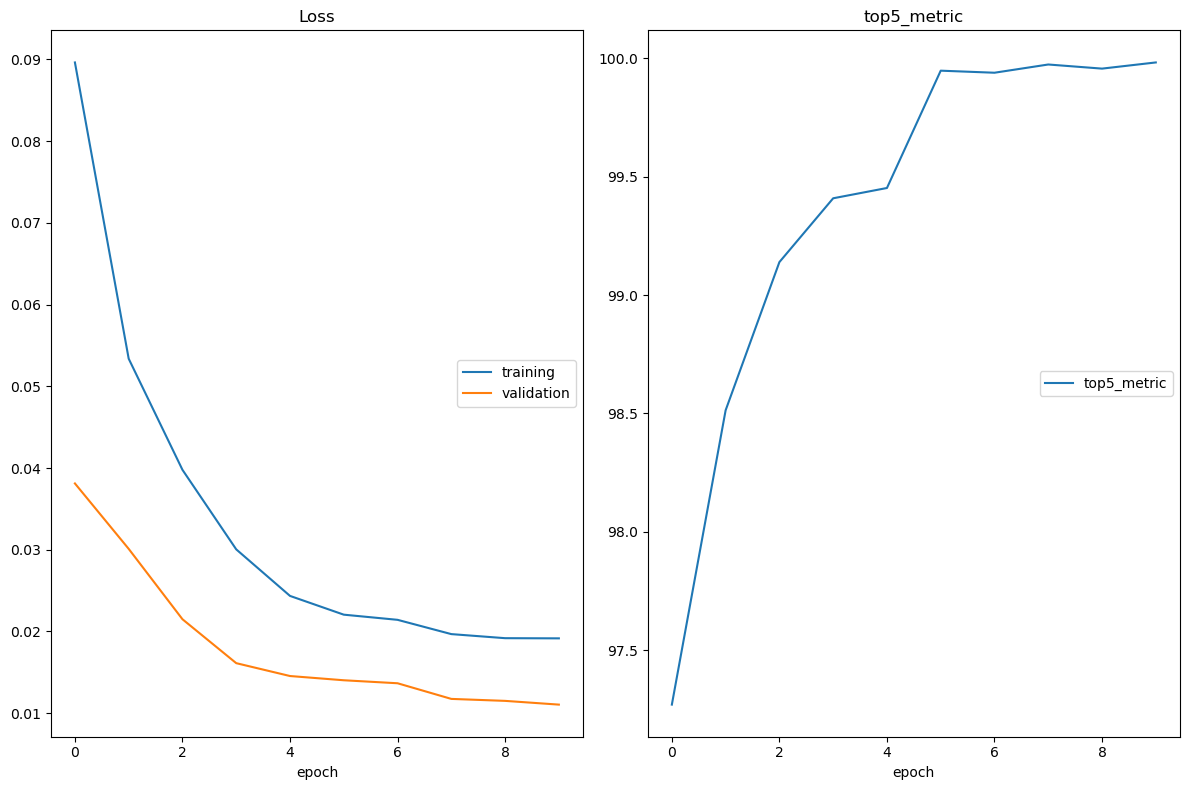

Loss
	training         	 (min:    0.019, max:    0.090, cur:    0.019)
	validation       	 (min:    0.011, max:    0.038, cur:    0.011)
top5_metric
	top5_metric      	 (min:   97.270, max:   99.983, cur:   99.983)
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - loss: 0.0193 - val_loss: 0.0111 - top5_metric: 99.9826


In [21]:
Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 callbacks = [CustomCallback(), PlotLossesKeras()]
                                )